# **Hate Speech Detector**

## **Model "bert-base-german-cased-sentiment-Germeval17"**

## 1. Load and prepare data

In [1]:
import pandas as pd
from google.colab import files
import io
uploaded = files.upload()

Saving hatespeech.csv to hatespeech (2).csv


In [2]:
df = pd.read_csv(io.BytesIO(uploaded['hatespeech.csv']),lineterminator='\n')

In [3]:
df.drop('Unnamed: 0',inplace=True,axis=1)

In [4]:
#shuffle data
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df.head()

,message,HateSpeech
0,Ca. 80 % der Einwanderer sind Muslime. Das Zie...,0
1,Sie wird nicht zu eineer Gefahr; Sie ist berei...,0
2,@Fuckologe @helllud123 dann retweetet die Wahr...,1
3,nun ... da müssen wir halt interkulturell komp...,0
4,Die Kurden. Das größte Volk der Welt ohne eige...,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19379 entries, 0 to 19378
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   message     19379 non-null  object
 1   HateSpeech  19379 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 302.9+ KB


In [7]:
df.shape

(19379, 2)

In [8]:
df['HateSpeech'].value_counts()

0    15138
1     4241
Name: HateSpeech, dtype: int64

## 2. Deep Learning

## 2.1. Install Simple Transformers library

In [9]:
# install simpletransformers
!pip install simpletransformers

# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.28.2

simpletransformers==0.63.3


## 2.2. Select a pre-trained language model

Simple Transformers library is based on the Transformers library from HuggingFace. This enables to use every pre-trained model provided in the Transformers library and all community-uploaded models. For a list of models refer to https://huggingface.co/models.

## 2.3. Train Test Split


In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.20)

print('train shape: ',train_df.shape)
print('test shape: ',test_df.shape)

train shape:  (15503, 2)
test shape:  (3876, 2)


## 2.4. Load pre-trained model

https://huggingface.co/deepset/bert-base-german-cased-sentiment-Germeval17

In [12]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "threshold": 0.6,
             "num_train_epochs": 10,
             'train_batch_size': 100,
             'use_early_stopping': True,
             'optimizer': 'AdamW',
             'early_stopping_metric': 'eval_loss' 
             }

# Create a ClassificationModel
sentiment_Germeval17_m = ClassificationModel(
    "bert", "deepset/bert-base-german-cased-sentiment-Germeval17",
    num_labels=2,
    weight=[0.5, 5],
    args=train_args,
    ignore_mismatched_sizes=True
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/bert-base-german-cased-sentiment-Germeval17 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 2.5. Train model

In [ ]:
# Train the model
sentiment_Germeval17_m.train_model(train_df)

  0%|          | 0/15503 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/156 [00:00<?, ?it/s]

## 3. Evaluation

## 3.1. Results

In [22]:
from sklearn.metrics import f1_score, accuracy_score

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = sentiment_Germeval17_m.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)

result

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1427: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/3876 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/485 [00:00<?, ?it/s]

{'mcc': 0.540929178393964,
 'tp': 516,
 'tn': 2771,
 'fp': 274,
 'fn': 315,
 'auroc': 0.8702759845794826,
 'auprc': 0.696011979849798,
 'f1': 0.8480392156862745,
 'acc': 0.8480392156862745,
 'eval_loss': 1.9389460143420458}

## 3.2. Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'True lables'
    cm.columns.name = 'Predicted labels'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [25]:
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

true = test_df['HateSpeech'].tolist()
predicted = lst

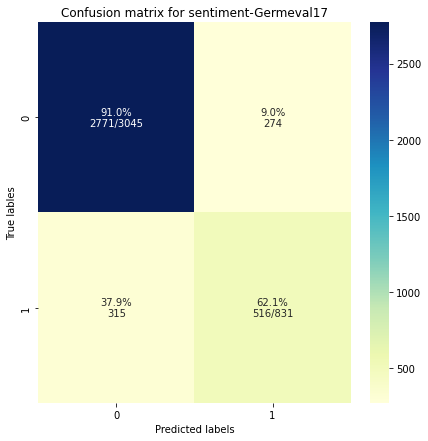

In [26]:
plot_cm(true, predicted, 'Confusion matrix for sentiment-Germeval17', figsize=(7,7))

## 3.3. Classification report

In [27]:
from sklearn import metrics
print(metrics.classification_report(true, predicted, digits=3))

              precision    recall  f1-score   support

           0      0.898     0.910     0.904      3045
           1      0.653     0.621     0.637       831

    accuracy                          0.848      3876
   macro avg      0.776     0.765     0.770      3876
weighted avg      0.845     0.848     0.847      3876



## 4. Predictions

In [29]:
class_list = ['Other','Hate Speech']

test_tweet = 'Muslime entwickeln sich langsam aber stetig zu einem bösartigen Tumor der dringend entfernt werden muss'

predictions, raw_outputs = sentiment_Germeval17_m.predict([test_tweet])

print(class_list[predictions[0]])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Hate Speech


In [30]:
class_list = ['Other','Hate Speech']

test_tweet = 'Während in Glasgow verhandelt wird, blockiert eine kleine Gruppe von Aktivisten die Straßen um London.'

predictions, raw_outputs = sentiment_Germeval17_m.predict([test_tweet])

print(class_list[predictions[0]])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Other


## 5. Save model

In [32]:
import pickle

pickle.dump(sentiment_Germeval17_m, open('germeval17.model', 'wb'))